In [2]:
# import library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn as sk
import pandas_profiling as pf
import string

# import additional library
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import _tree
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier



# import modules for Hyperparameter Tuning
from scipy.stats import randint
from sklearn.utils import check_random_state
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import  cross_val_score


#  Hide all warnings
import warnings
warnings.filterwarnings("ignore")

# Import graphviz
import graphviz


# Load Data

In [4]:
#read data housing
phisingData = pd.read_csv("phishing_final.csv", delimiter=",") 

In [234]:
# Get the important feedback on features in data set
phisingData.describe()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,Domain_registeration_length,Favicon,port,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
count,11055,9947,9937,9957,9952,11055,11055,11055,11055,11055,...,11055,11055,9971,9934,9941,9982,9961,11055,11055,10001
unique,2,3,2,2,2,2,3,2,2,2,...,2,2,2,2,3,2,2,3,2,2
top,Yes,Short,Yes,Yes,Yes,No,More than one,Short,Yes,Yes,...,Yes,Yes,Long,Yes,High,Low,Yes,Some links,Reported,Phish
freq,7262,8078,8641,8474,8649,9590,4070,7389,9002,9553,...,8918,10043,5316,6832,5244,7382,8562,6156,9505,5560


In [5]:
# Get a summary report on the original data set
pf.ProfileReport(phisingData)

Number of variables,30
Number of observations,11055
Total Missing (%),5.3%
Total size in memory,2.5 MiB
Average record size in memory,240.0 B
Numeric,0
Categorical,30
Date,0
Text (Unique),0
Rejected,0
Distinct count,2


## Pre-Processing Data

In [5]:
# Drop all rows that contain empty conclusion on result feature
phisingData = phisingData.dropna(subset=['Result'])

In [6]:
# Create a new feature that combined from URL length and Shortening Service
phisingData['Shortining_Service'] = phisingData['Shortining_Service'].replace({'Yes': 'Short', 'No': 'Long'})
phisingData.loc[phisingData['URL_Length'].isnull(),'URL_Length'] = phisingData['Shortining_Service']
# Drop the Shortining_Service feature
phisingData = phisingData.drop(columns='Shortining_Service', axis=1)
# Re-check 
print("The null values in URL_Length feature has reduced to " +str(phisingData['URL_Length'].isnull().sum()))

The null values in URL_Length feature has reduced to 101


In [7]:
# Remove all missing values
phisingData = phisingData.dropna()

In [8]:
# Feature Selection (divided the original data set into four different groups) 

# Group A: All features that relatated to the presence of web
cols_select=['age_of_domain', 'web_traffic', 'Page_Rank', 'Google_Index']
phisingLiteA = phisingData[cols_select]
# Group B: All features that contains only two possible outcomes
cols_drop=['URL_Length', 'having_Sub_Domain', 'URL_of_Anchor', 'Links_in_tags','SFH','web_traffic',
           'Links_pointing_to_page','Result']
phisingLiteB = phisingData.drop(columns=cols_drop)
# Group C: All features that contains only three possible outcomes
cols_select=['URL_Length', 'having_Sub_Domain', 'URL_of_Anchor', 'Links_in_tags','SFH','web_traffic', 
             'Links_pointing_to_page']
phisingLiteC = phisingData[cols_select]
# Group D: All features (combine group B and C)
# phisingLiteD  = phisingData.drop('Result', axis=1)
phisingLiteD  = pd.concat([phisingLiteB,phisingLiteC], axis=1)
# Group E: All important features that conducted by applying feature_important function of Random Decision Tree (available in extension work)
cols_drop=['having_At_Symbol', 'double_slash_redirecting', 'Favicon','port','Submitting_to_email',
           'Abnormal_URL', 'Redirect','on_mouseover', 'RightClick','popUpWidnow','Iframe', 'Statistical_report','Result']
phisingLiteE = phisingData.drop(columns=cols_drop)

# Convert Data

In [9]:
#  Slice data
phisingDataTarget = phisingData[["Result"]]
phisingDataAttrs = phisingData.drop('Result', axis=1)

# Convert string data into numberic values by using get dummies function
phisingDataAttrsEx = pd.get_dummies(phisingDataAttrs)
phisingAttrsExA  = pd.get_dummies(phisingLiteA)
phisingAttrsExB  = pd.get_dummies(phisingLiteB)
phisingAttrsExC  = pd.get_dummies(phisingLiteC)
phisingAttrsExD  = pd.get_dummies(phisingLiteD)
phisingAttrsExE  = pd.get_dummies(phisingLiteE)

In [10]:
# Convert string data of the target into numberic values
le = preprocessing.LabelEncoder()
le.fit(phisingDataTarget)

class_labels = le.inverse_transform([0,1])

print(np.array(phisingDataTarget))
print('Labels to normalised encoding')
print(le.transform(phisingDataTarget))
print('Labels to original encoding')
print(class_labels)

[['Phish']
 ['Phish']
 ['Phish']
 ...
 ['Not phish']
 ['Not phish']
 ['Not phish']]
Labels to normalised encoding
[1 1 1 ... 0 0 0]
Labels to original encoding
['Not phish' 'Phish']


# Train Whole Original Data Set

In [11]:
clfPhish = tree.DecisionTreeClassifier(criterion='entropy',random_state=0)
clfPhish = clfPhish.fit(phisingDataAttrsEx, phisingDataTarget)
predictions = clfPhish.predict(phisingDataAttrsEx)
print(metrics.classification_report(phisingDataTarget, predictions))

              precision    recall  f1-score   support

   Not phish       0.99      0.99      0.99      1114
       Phish       0.99      0.99      0.99      1434

   micro avg       0.99      0.99      0.99      2548
   macro avg       0.99      0.99      0.99      2548
weighted avg       0.99      0.99      0.99      2548



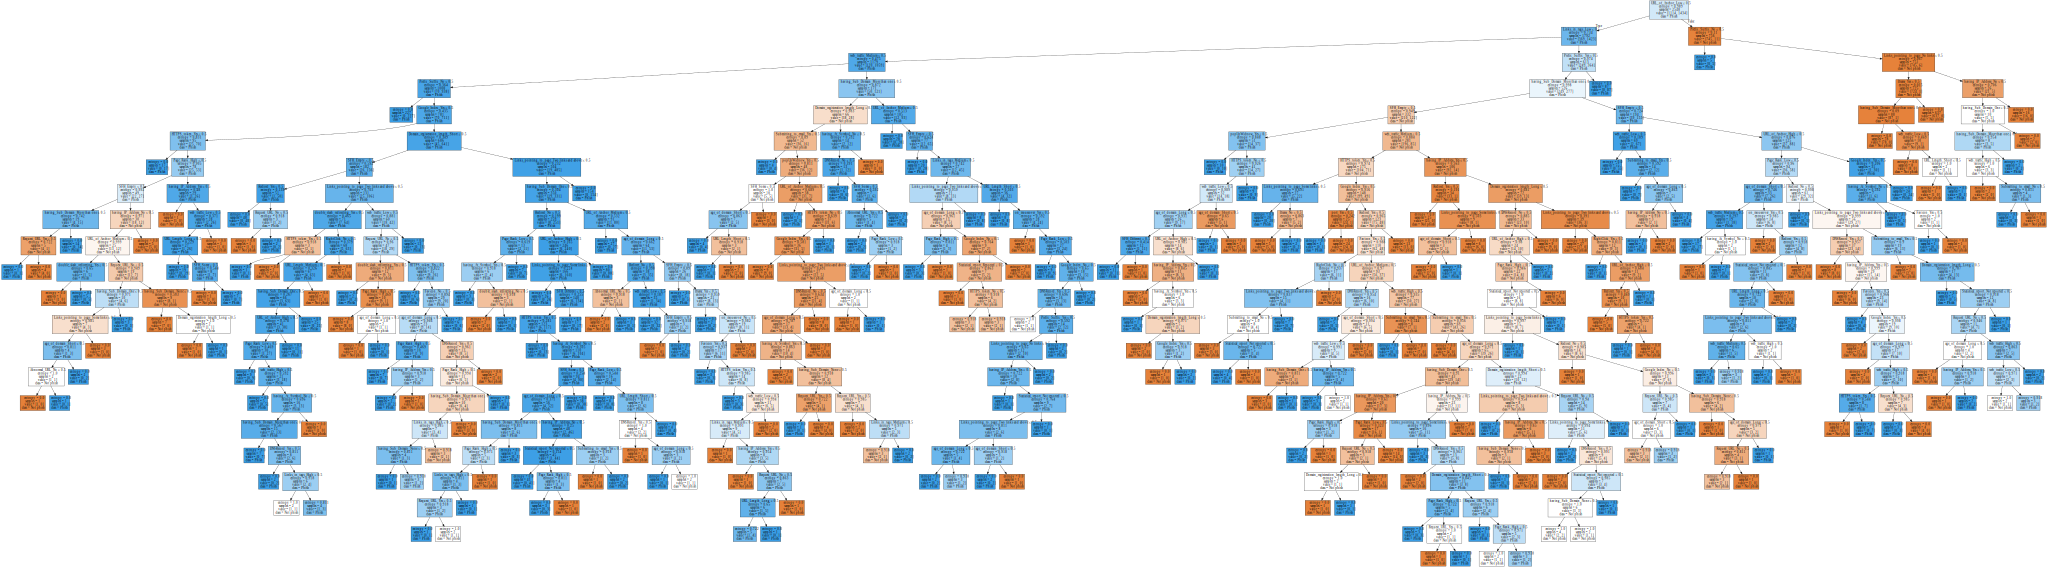

In [12]:
# Draw graphviz
dot_data = tree.export_graphviz(clfPhish, out_file=None, feature_names=phisingDataAttrsEx.columns, class_names=class_labels, filled=True, rounded=False, special_characters=True)
graph = graphviz.Source(dot_data)
graph

# Create Necessary Function

In [70]:
def split_data_and_apply_decisiontree(data):
    # Spliting the data set into Train and Test set
    trainX, testX, trainY, testY = train_test_split(data, phisingDataTarget, test_size=0.2, random_state=0)
    
    # Fitting classifier to Training set
    clfPhising = DecisionTreeClassifier(criterion="entropy", random_state=0)
    clfPhising.fit(trainX,trainY)
    # Predict the output by using conducted model
    pred_phish = clfPhising.predict(testX)
    
    # Printout the result for model`s performance
    cm = confusion_matrix(testY,pred_phish)
    print("Node Count: " +str(clfPhising.tree_.node_count))
    print("--------------------------------------------------")
    print("Accuracy Score: " +str(accuracy_score(testY,pred_phish)))
    print("--------------------------------------------------")
    print("Confusion matrix: ")
    print(cm)
    print("--------------------------------------------------")
    print("Classification report: ")
    print(metrics.classification_report(testY, pred_phish))
    print("\n")

In [91]:
def cross_validation_data(attr):
    # Setting parameters for the cross validation
    kfold = model_selection.KFold(n_splits=10, random_state=7)

    #  Instantiates the model
    model = RandomForestClassifier() 

    # Printout result
    results = model_selection.cross_val_score(model, attr, phisingDataTarget, cv=kfold)
    print("All gained results: ")
    print(results)
    print("-----------------------------------------------------------------")
    print("Mean of result: " +str(results.mean()))

# Training Classifier From Splited Data Set (A, B, C, D)

In [170]:
# Group A
print("The performance of conducted model on set A:")
split_data_and_apply_decisiontree(phisingAttrsExA)
print("After Apply Cross-Validation: ")
cross_validation_data(phisingAttrsExA)

The performance of conducted model on set A:
Node Count: 47
--------------------------------------------------
Accuracy Score: 0.7549019607843137
--------------------------------------------------
Confusion matrix: 
[[163  73]
 [ 52 222]]
--------------------------------------------------
Classification report: 
              precision    recall  f1-score   support

   Not phish       0.76      0.69      0.72       236
       Phish       0.75      0.81      0.78       274

   micro avg       0.75      0.75      0.75       510
   macro avg       0.76      0.75      0.75       510
weighted avg       0.76      0.75      0.75       510



After Apply Cross-Validation: 
All gained results: 
[0.8        0.80784314 0.80784314 0.78431373 0.54117647 0.58823529
 0.64705882 0.68627451 0.56692913 0.27165354]
-----------------------------------------------------------------
Mean of result: 0.6501327775204571


In [171]:
# Group B
print("The performance of conducted model on set B:")
split_data_and_apply_decisiontree(phisingAttrsExB)
print("After Apply Cross-Validation: ")
cross_validation_data(phisingAttrsExB)

The performance of conducted model on set B:
Node Count: 675
--------------------------------------------------
Accuracy Score: 0.7588235294117647
--------------------------------------------------
Confusion matrix: 
[[170  66]
 [ 57 217]]
--------------------------------------------------
Classification report: 
              precision    recall  f1-score   support

   Not phish       0.75      0.72      0.73       236
       Phish       0.77      0.79      0.78       274

   micro avg       0.76      0.76      0.76       510
   macro avg       0.76      0.76      0.76       510
weighted avg       0.76      0.76      0.76       510



After Apply Cross-Validation: 
All gained results: 
[0.75294118 0.80392157 0.7372549  0.58431373 0.69019608 0.69803922
 0.65490196 0.62745098 0.43700787 0.27559055]
-----------------------------------------------------------------
Mean of result: 0.6261618033039988


In [97]:
# Group C
print("The performance of conducted model on set C:")
split_data_and_apply_decisiontree(phisingAttrsExC)
print("After Apply Cross-Validation: ")
cross_validation_data(phisingAttrsExC)

The performance of conducted model on set C:
Node Count: 319
--------------------------------------------------
Accuracy Score: 0.888235294117647
--------------------------------------------------
Confusion matrix: 
[[208  28]
 [ 29 245]]
--------------------------------------------------
Classification report: 
              precision    recall  f1-score   support

   Not phish       0.88      0.88      0.88       236
       Phish       0.90      0.89      0.90       274

   micro avg       0.89      0.89      0.89       510
   macro avg       0.89      0.89      0.89       510
weighted avg       0.89      0.89      0.89       510



After Apply Cross-Validation: 
All gained results: 
[0.8745098  0.8745098  0.89803922 0.95294118 0.91372549 0.90980392
 0.85490196 0.86666667 0.80708661 0.78346457]
-----------------------------------------------------------------
Mean of result: 0.8735649220318049


In [127]:
# Group D
print("The performance of conducted model on set D:")
split_data_and_apply_decisiontree(phisingAttrsExD)
print("After Apply Cross-Validation: ")
cross_validation_data(phisingAttrsExD)

The performance of conducted model on set D:
Node Count: 477
--------------------------------------------------
Accuracy Score: 0.907843137254902
--------------------------------------------------
Confusion matrix: 
[[212  24]
 [ 23 251]]
--------------------------------------------------
Classification report: 
              precision    recall  f1-score   support

   Not phish       0.90      0.90      0.90       236
       Phish       0.91      0.92      0.91       274

   micro avg       0.91      0.91      0.91       510
   macro avg       0.91      0.91      0.91       510
weighted avg       0.91      0.91      0.91       510



After Apply Cross-Validation: 
All gained results: 
[0.88235294 0.88627451 0.90196078 0.94509804 0.90588235 0.91372549
 0.89019608 0.89411765 0.82677165 0.7992126 ]
-----------------------------------------------------------------
Mean of result: 0.8845592095105758


# Training Classifier From The Final Set

In [137]:
# Spliting the data set into Train and Test set
trainX, testX, trainY, testY = train_test_split(phisingAttrsExE, phisingDataTarget, test_size=0.2, random_state=0)

# Fitting classifier to Training set
clfPhising = DecisionTreeClassifier(criterion="entropy", random_state=0)
clfPhising.fit(trainX,trainY)
# Predict the output by using conducted model
pred_phish = clfPhising.predict(testX)
    
# Printout the result for model`s performance
cm = confusion_matrix(testY,pred_phish)
print("The performance of conducted model on set E:")
print("Node Count: " +str(clfPhising.tree_.node_count))
print("--------------------------------------------------")
print("Confusion matrix: ")
print(cm)
print("--------------------------------------------------")
print("Accuracy Score: " +str(accuracy_score(testY,pred_phish)))
print("--------------------------------------------------")
print("Classification report: ")
print(metrics.classification_report(testY, pred_phish))
print("\n")
print("After Apply Cross-Validation: ")
cross_validation_data(phisingAttrsExE)

The performance of conducted model on set E:
Node Count: 509
--------------------------------------------------
Confusion matrix: 
[[219  17]
 [ 20 254]]
--------------------------------------------------
Accuracy Score: 0.9274509803921569
--------------------------------------------------
Classification report: 
              precision    recall  f1-score   support

   Not phish       0.92      0.93      0.92       236
       Phish       0.94      0.93      0.93       274

   micro avg       0.93      0.93      0.93       510
   macro avg       0.93      0.93      0.93       510
weighted avg       0.93      0.93      0.93       510



After Apply Cross-Validation: 
All gained results: 
[0.89019608 0.9372549  0.90196078 0.94901961 0.92941176 0.91372549
 0.87058824 0.91764706 0.82677165 0.81496063]
-----------------------------------------------------------------
Mean of result: 0.8951536205033195


In [102]:
# Due to the conducted result on performance of each group , the final group (group E) seems to bring out the best accuracy score
# without needing too many attributes (only 16 features). Therefore, in futher work, the main focus will be on this group set only.

#   Parameters Tunning (only with the group E )

In [86]:
# Set up the range for all parameters that need to be tunning
param_dist = {
              "min_samples_split": randint(2, 20),
              "max_depth": randint(1, 20),
              "min_samples_leaf": randint(1, 20)
             }

# Create a new model of decision tree
model = DecisionTreeClassifier(criterion="entropy", random_state=0)

# Apply the provided model and parameter settings to RandomziedSearch function
model_cv = RandomizedSearchCV(model, param_dist, cv=10)
# model_cv = GridSearchCV(model, param_grid=param_grid, cv=10)

# Fit it to the splitted data from shorten set
model_cv.fit(trainX,trainY)

# Predict the results
pred_y = model_cv.predict(testX)

# Printout the result
print("When the number of cross-validation splits: " +str(model_cv.n_splits_ ))
print("------------------------------------------------")
print("Best Tunned Decision Tree Parameters: ")
print(model_cv.best_params_)
print("------------------------------------------------")
print("Best conducted score is {}".format(model_cv.best_score_))
print("------------------------------------------------")

# Finding the Confusion Matrix
cm = confusion_matrix(testY,pred_y)
print("Confusion matrix: ")
print(cm)
print("------------------------------------------------")

# Try to split a result into int
result = str(model_cv.best_params_)
result = result.replace(',', '')
result = result.replace('}', '')
result = result.split()
# Apply the conducted parameter settings to findout the node count 
bestmodel = DecisionTreeClassifier(criterion="entropy", max_depth=int(result[3]), min_samples_split=int(result[1]), min_samples_leaf=int(result[5]), random_state=0)
bestmodel.fit(trainX,trainY)
bestPred = bestmodel.predict(testX)
print("After applying new settings on parameters:")
print("Node Count: " +str(bestmodel.tree_.node_count))
print("Accuracy Score: " +str(accuracy_score(testY,bestPred)))

When the number of cross-validation splits: 10
------------------------------------------------
Best Tunned Decision Tree Parameters: 
{'min_samples_split': 6, 'max_depth': 8, 'min_samples_leaf': 8}
------------------------------------------------
Best conducted score is 0.895976447498
------------------------------------------------
Confusion matrix: 
[[216  20]
 [ 21 253]]
------------------------------------------------
After applying new settings on parameters:
Node Count: 99
Accuracy Score: 0.9196078431372549


# EXTENSION WORK :  Apply Ensemble Methods (group E only)

In [22]:
# Create necessary function to tunning parameters for the base_estimators
def tunning_function(pd, model, cv):
    
    # Apply the provided model and parameter settings to RandomziedSearch function
    model_cv = RandomizedSearchCV(model, param_dist, cv=cv)

    # Fit it to the splitted data from shorten set
    model_cv.fit(trainX,trainY)

    # Predict the results
    pred_y = model_cv.predict(testX)

    # Printout the result
    print("Best Tunned Parameters: ")
    print(model_cv.best_params_)
    print("------------------------------------------------")
    print("Best conducted score is {}".format(model_cv.best_score_))
    print("\n")

# 1. Random Forest Decision Trees

In [240]:
# A. Find all features that important in classifying the data set based on functions provided by Random Forest Decision Trees

# Split the original data set into  new train and test set 
trainX_ori, testX_ori, trainY_ori, testY_ori = train_test_split(phisingDataAttrsEx,phisingDataTarget, test_size=0.2, random_state=0)

# Instantiates the model. 
rf = RandomForestClassifier() 

# Fit the model on your training data
rf_model = rf.fit(trainX_ori, trainY_ori) 

#Printout the score gaining from testing on test set
print("Accuracy Score: " + str(rf.score(testX_ori, testY_ori)))
print("\n")

# B.  Applying cross-validation on the data set

# Setting parameters for the cross validation
kfold = model_selection.KFold(n_splits=10, random_state=7)

#  Instantiates the model
model = RandomForestClassifier() 

# Printout result
results = model_selection.cross_val_score(model, phisingDataAttrsEx, phisingDataTarget, cv=kfold)
print("After apply cross-validation: ")
print("All gained results: ")
print(results)
print("-----------------------------------------------------------------")
print("Mean of result: " +str(results.mean()))

# Findout the important features
feature_imp = pd.Series(rf.feature_importances_,index=phisingDataAttrsEx.columns).sort_values(ascending=False)

Accuracy Score: 0.9392156862745098


After apply cross-validation: 
All gained results: 
[0.89803922 0.91372549 0.88627451 0.90588235 0.89019608 0.92941176
 0.87843137 0.89411765 0.83858268 0.79527559]
-----------------------------------------------------------------
Mean of result: 0.8829936699089084


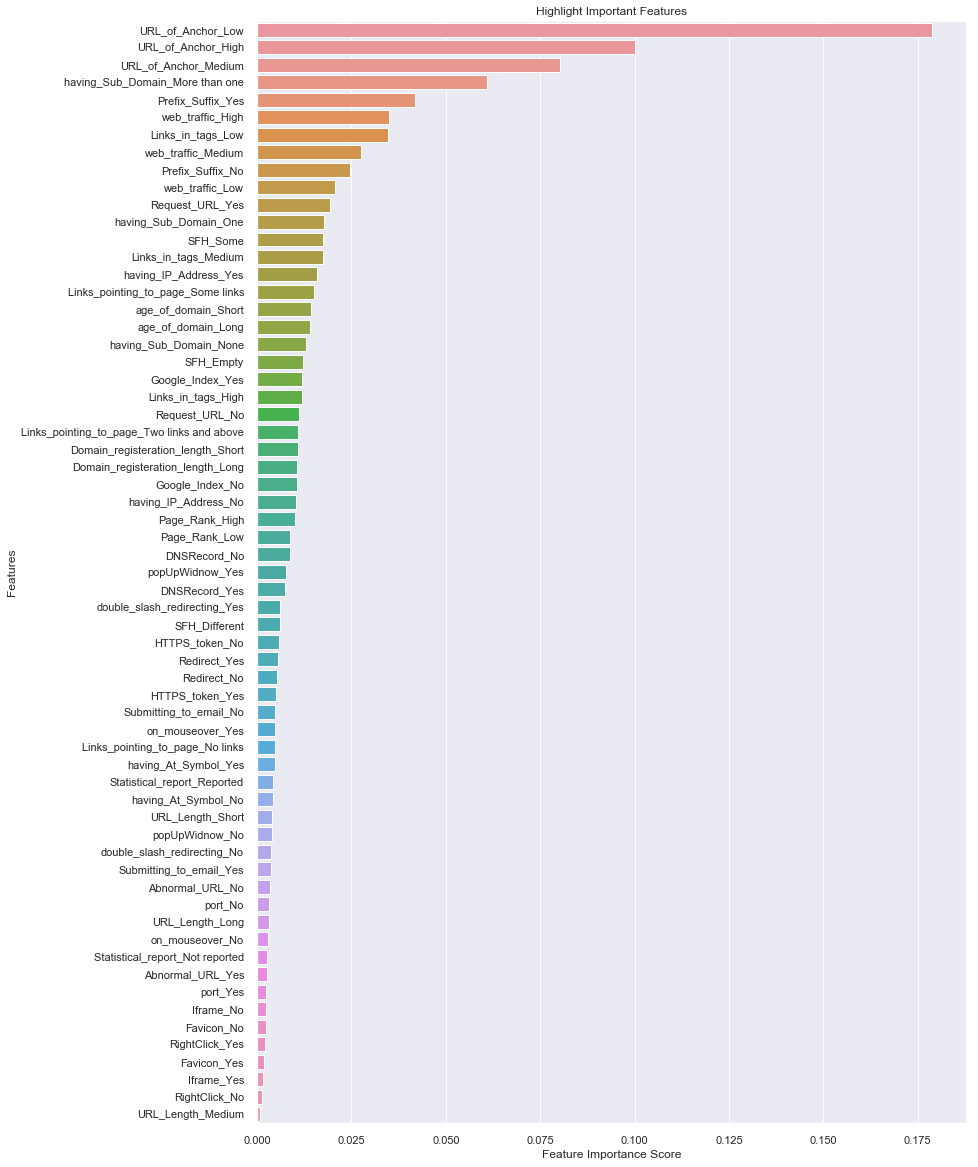

In [173]:
# B.Draw a graph in order to highlight the important features
%matplotlib inline
# Creating a bar plot
sns.set(rc={'figure.figsize':(12.7,20.27)})
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Highlight Important Features")
plt.legend()
plt.show()

In [25]:
# All features in group E are selected based on above conducted result. To elaborate, all features that contain one behavior
# which gaining the high value of important ( >0.01) are being choosen .

In [53]:
# C.  Paramater Tunning for the Random Forest Decision Tree

# Set up the range for all parameters that need to be tunning
param_dist = {  "n_estimators": [1, 2, 4, 8, 16, 32, 64, 100, 200],
                "min_samples_split": randint(2, 20),
                "max_depth": randint(1, 20),
                "min_samples_leaf": randint(1, 20) }

# Create a new model of decision tree
model = RandomForestClassifier()

# Apply the provided model and parameter settings to RandomziedSearch function
model_cv = RandomizedSearchCV(model, param_dist, cv=10)

# Fit it to the splitted data from shorten set
model_cv.fit(trainX,trainY)

# Predict the results
pred_y = model_cv.predict(testX)

# Printout the result
print("When the number of cross-validation splits: " +str(model_cv.n_splits_ ))
print("------------------------------------------------")
print("Best Tunned Parameters: ")
print(model_cv.best_params_)
print("------------------------------------------------")
print("Best conducted score is {}".format(model_cv.best_score_))
print("------------------------------------------------")

# Finding the Confusion Matrix
cm = confusion_matrix(testY,pred_y)
print("Confusion matrix: ")
print(cm)
print("------------------------------------------------")

When the number of cross-validation splits: 10
------------------------------------------------
Best Tunned Parameters: 
{'min_samples_split': 13, 'n_estimators': 16, 'max_depth': 12, 'min_samples_leaf': 6}
------------------------------------------------
Best conducted score is 0.912168792934
------------------------------------------------
Confusion matrix: 
[[205  31]
 [ 14 260]]
------------------------------------------------


In [250]:
# D. Trying apply again the Random Forest Decision Trees with conducted parameters settings on important data set (Group E)
   
# Instantiates the model. 
rf = RandomForestClassifier(min_samples_split = 13, n_estimators = 16, max_depth = 12, min_samples_leaf = 6) 

# Fit the model on your training data
rf_model = rf.fit(trainX, trainY) 
 
#Printout the score gaining from testing on test set
print("Accuracy Score: " + str(rf.score(testX, testY)))
print("\n")

# B.  Applying cross-validation on the data set

# Setting parameters for the cross validation
kfold = model_selection.KFold(n_splits=10, random_state=7)

#  Instantiates the model
model = RandomForestClassifier(min_samples_split = 13, n_estimators = 16, max_depth = 12, min_samples_leaf = 6) 

# Printout result
results = model_selection.cross_val_score(model, phisingAttrsExE, phisingDataTarget, cv=kfold)
print("After apply cross-validation: ")
print("All gained results: ")
print(results)
print("-----------------------------------------------------------------")
print("Mean of result: " +str(results.mean()))

Accuracy Score: 0.9176470588235294


After apply cross-validation: 
All gained results: 
[0.92156863 0.92941176 0.89019608 0.93333333 0.92156863 0.93333333
 0.87058824 0.90196078 0.84251969 0.80314961]
-----------------------------------------------------------------
Mean of result: 0.894763007565231


# 2 . AdaBoost Classifier 

In [177]:
# Create necessary function in exploring ensemble method
def apply_adaboost_emethod (base_estimator):
    adb_default = AdaBoostClassifier(base_estimator = base_estimator, n_estimators=50, learning_rate=1)

    # Train Adaboost Classifer
    adb_model = adb_default.fit(trainX, trainY)

    #Predict the response for test dataset
    pred_Y = adb_model.predict(testX)

    # Printout the accuracy score
    print("Accuracy Score: " + str(metrics.accuracy_score(testY, pred_Y)))

In [30]:
# A. Parameter tunning for different methods

# LogisticRegression()
param_dist = {
                "dual": [True,False],
                 "C": [0.001,0.01,0.1,1,10,100,1000],
                "max_iter": [100,110,120,130,140]         
             }
print("Logistic Regression")
tunning_function(param_dist, LogisticRegression(), 10)

# ExtraTreesClassifier()
param_dist = {
              "n_estimators": [16, 32],
              "min_samples_split": randint(2, 20),
              "max_depth": randint(1, 20),
              "min_samples_leaf": randint(1, 20)       
             }
print("Extra Trees Classifier")
tunning_function(param_dist, ExtraTreesClassifier(), 10)

Logistic Regression
Best Tunned Parameters: 
{'C': 1000, 'max_iter': 110, 'dual': False}
------------------------------------------------
Best conducted score is 0.903336604514


Extra Trees Classifier
Best Tunned Parameters: 
{'min_samples_split': 5, 'n_estimators': 32, 'max_depth': 18, 'min_samples_leaf': 2}
------------------------------------------------
Best conducted score is 0.919038272816




In [178]:
# B. Testing conducted parameters on the base_estimators of Adaboost Classifier

# Trying with the default base estimator: DecisionTreeClassifier
print("Base_Estimator: None")
apply_adaboost_emethod (None)
print("\n")

# Trying with the another base estimator: LogisticRegression
# Create a SVC object 
lgr = LogisticRegression(C = 1000, max_iter = 110, dual = False)
# Using prepared function
print("Base_Estimator: LogisticRegression")
apply_adaboost_emethod (lgr)
print("\n")

# Trying with the another base estimator: ExtraTreesClassifier
# Create a ExtraTreesClassifier object 
etc = ExtraTreesClassifier(min_samples_split = 5, n_estimators = 32, max_depth = 18, min_samples_leaf = 2)
# Using prepared function
print("Base_Estimator: ExtraTreesClassifier")
apply_adaboost_emethod (etc)
print("\n")

Base_Estimator: None
Accuracy Score: 0.9


Base_Estimator: LogisticRegression
Accuracy Score: 0.8980392156862745


Base_Estimator: ExtraTreesClassifier
Accuracy Score: 0.9313725490196079




In [43]:
# C. Tunning prameter settings of Adaboost method on different base estimators

# Create a suitable function
def evaluate_adaboost_classification():
    # Check classification for various parameter settings.
    rng = check_random_state(0)
    param_dist = { 'n_estimators': [50, 100],
                'learning_rate' : [0.01,0.05,0.1,0.3,1]}
    
    for base_estimator in [None,
                           lgr,
                           etc]:
        # Create a model with each base estimator
        model = AdaBoostClassifier(base_estimator=base_estimator,
                              random_state=rng)
        model_cv = RandomizedSearchCV(model, param_dist, cv=10)
        model_cv.fit(trainX, trainY)
        pred_Y = model_cv.predict(testX) 
        # Printout the result
        print(str(base_estimator))
        print("------------------------------------------------")
        print("Best Tunned Parameters: ")
        print(model_cv.best_params_)
        print("------------------------------------------------")
        print("Best conducted score is {}".format(model_cv.best_score_))
        print("------------------------------------------------")
        # Finding the Confusion Matrix
        cm = confusion_matrix(testY,pred_Y)
        print("Confusion matrix: ")
        print(cm)
        print("\n")
        
# Callout function
evaluate_adaboost_classification()

None
------------------------------------------------
Best Tunned Parameters: 
{'n_estimators': 50, 'learning_rate': 0.3}
------------------------------------------------
Best conducted score is 0.906331763475
------------------------------------------------
Confusion matrix: 
[[250  47]
 [ 20 320]]


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=110, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
------------------------------------------------
Best Tunned Parameters: 
{'n_estimators': 50, 'learning_rate': 0.05}
------------------------------------------------
Best conducted score is 0.903192046049
------------------------------------------------
Confusion matrix: 
[[259  38]
 [ 28 312]]


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=18, max_features='auto', max_leaf_nod

# 3. Bagging 

In [34]:
# Create necessary function in exploring ensemble method
def apply_bagging_emethod (base_estimator):
    #  Instantiates the model 
    bag = BaggingClassifier(base_estimator=base_estimator, n_estimators=50)
    
    # Train Adaboost Classifer
    bag_model = bag.fit(trainX, trainY)
    
    #Predict the output for test dataset
    pred_Y = bag_model.predict(testX)
    
    # Printout the accuracy score
    print("Accuracy Score: " + str(metrics.accuracy_score(testY, pred_Y)))

In [35]:
# A. Parameter tunning for different methods

# SVC
param_dist = {  "kernel": ["linear", "rbf"], 
                "C": [0.1, 1, 10, 100, 1000],
                "gamma": [0.1, 1, 10, 100],
                "degree": [0, 1, 2, 3, 4, 5, 6]} 
print("SVC")
tunning_function(param_dist, SVC(), 10)

# KNeighborsClassifier
param_dist = {"n_neighbors": randint(1, 30),
              "p": [1, 2, 3, 4, 5]}
print("KNeighborsClassifier")
tunning_function(param_dist, KNeighborsClassifier(), 10)

# Perceptron
param_dist = {"penalty" :  ["l2",  "l1"],
              "max_iter": [100,110,120,130,140]}
print("Perceptron")
tunning_function(param_dist, Perceptron(), 10)

SVC
Best Tunned Parameters: 
{'kernel': 'linear', 'C': 1, 'degree': 4, 'gamma': 100}
------------------------------------------------
Best conducted score is 0.909715407262


KNeighborsClassifier
Best Tunned Parameters: 
{'n_neighbors': 14, 'p': 2}
------------------------------------------------
Best conducted score is 0.899411187439


Perceptron
Best Tunned Parameters: 
{'penalty': 'l1', 'max_iter': 110}
------------------------------------------------
Best conducted score is 0.881746810599




In [46]:
# B. Testing conducted parameters on the base_estimators of Adaboost Classifier

# Trying with the default base estimator: DecisionTreeClassifier
print("Base_Estimator: None")
apply_bagging_emethod (None)
print("\n")

# Trying with the another base estimator: SVC
# Create a SVC object 
svc = SVC(kernel='linear', C=1, degree=4, gamma=100, probability=True)
# Using prepared function
print("Base_Estimator: SVC")
apply_bagging_emethod (svc)
print("\n")

# Trying with the another base estimator: KNeighborsClassifier
# Create a ExtraTreesClassifier object 
knc = KNeighborsClassifier(n_neighbors=14, p=2)
# Using prepared function
print("Base_Estimator: KNeighborsClassifier")
apply_bagging_emethod (knc)

# Trying with the another base estimator: Perceptron
# Create a ExtraTreesClassifier object 
percep = Perceptron(penalty = 'l1', max_iter = 110)
print("\n")
# Using prepared function
print("Base_Estimator: Perceptron")
apply_bagging_emethod (percep)

Base_Estimator: None
Accuracy Score: 0.9235294117647059


Base_Estimator: SVC
Accuracy Score: 0.9019607843137255


Base_Estimator: KNeighborsClassifier
Accuracy Score: 0.9


Base_Estimator: Perceptron
Accuracy Score: 0.9058823529411765


In [47]:
# C. Tunning prameter settings of Bagging method on different base estimators

# Create a suitable function
def evaluate_classification_bagging():
    # Check classification for various parameter settings.
    rng = check_random_state(0)
    param_dist = {
                        "max_samples": [0.5, 1.0],
                        "max_features": [1, 2, 4],
                        "bootstrap": [True, False],
                        "bootstrap_features": [True, False]}
    
    for base_estimator in [None,
                           svc,
                           knc,
                           percep]:
        # Create a model with each base estimator
        model = BaggingClassifier(n_estimators=50,base_estimator=base_estimator,
                              random_state=rng)
        model_cv = RandomizedSearchCV(model, param_dist, cv=10)
        model_cv.fit(trainX, trainY)
        pred_Y = model_cv.predict(testX) 
        # Printout the result
        print(str(base_estimator))
        print("------------------------------------------------")
        print("Best Tunned Decision Tree Parameters: ")
        print(model_cv.best_params_)
        print("------------------------------------------------")
        print("Best conducted score is {}".format(model_cv.best_score_))
        print("------------------------------------------------")
        # Finding the Confusion Matrix
        cm = confusion_matrix(testY,pred_Y)
        print("Confusion matrix: ")
        print(cm)
        print("\n")
        
# Callout preapred function
evaluate_classification_bagging()

None
------------------------------------------------
Best Tunned Decision Tree Parameters: 
{'max_features': 4, 'max_samples': 0.5, 'bootstrap': False, 'bootstrap_features': False}
------------------------------------------------
Best conducted score is 0.878597592883
------------------------------------------------
Confusion matrix: 
[[227  70]
 [  7 333]]


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=4, gamma=100, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
------------------------------------------------
Best Tunned Decision Tree Parameters: 
{'max_features': 4, 'max_samples': 1.0, 'bootstrap': True, 'bootstrap_features': False}
------------------------------------------------
Best conducted score is 0.850863422292
------------------------------------------------
Confusion matrix: 
[[215  82]
 [  0 340]]


KNeighborsClassifier(algorithm='auto', leaf_size=30, metri

# 4 .Classifier Voting

In [201]:
# A. Trying apply the voting classifier on data set

# Instantiates the model.
dtc = DecisionTreeClassifier(min_samples_split = 4, max_depth = 8, min_samples_leaf = 1) 
voting_clf = VotingClassifier(
    estimators = [('lr', lgr), ('cart', dtc), ('rf',rf)],
    voting = 'hard')
voting_clf.fit(trainX, trainY)
pred_Y = voting_clf.predict(testX) 

# Printout result
print("The conducted accuracy score: " +str(metrics.accuracy_score(testY, pred_Y)))

The conducted accuracy score: 0.9274509803921569


In [209]:
# B. Applying cross-validation on the data set

# Parameter settings for K-fold cross validation
kfold = model_selection.KFold(n_splits=10, random_state=7)

# Prepare the sub models
estimators = []
estimators.append(('logistic', lgr))
estimators.append(('cart', dtc))
estimators.append(('rf', rf))

# Instantiates the model.
ensemble = VotingClassifier(estimators)

# Printout result
results = model_selection.cross_val_score(model, phisingAttrsExE, phisingDataTarget, cv=kfold)
print("All gained results: ")
print(results)
print("-----------------------------------------------------------------")
print("Mean of result: " +str(results.mean()))

All gained results: 
[0.87843137 0.89803922 0.88627451 0.90980392 0.89411765 0.91372549
 0.87843137 0.90588235 0.83464567 0.79133858]
-----------------------------------------------------------------
Mean of result: 0.8790690134321444
